In [1]:
import re
import os
from PIL import Image
import imagehash
from typing import Optional, Set
from loguru import logger
import imageio.v3 as iio
import re
import numpy as np
import json
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from tqdm import tqdm

In [2]:
CACHE_DIR = r'C:\Users\Jonathan\.mkv-episode-matcher\cache'

In [12]:
def hashes_are_similar(hash1, hash2, threshold=20):
    """
    Determine if two perceptual hashes are similar within a given threshold.
    
    Args:
    - hash1: The first perceptual hash to compare.
    - hash2: The second perceptual hash to compare.
    - threshold: The maximum allowed difference between the hashes for them to be considered similar.
    
    Returns:
    - A tuple containing two values:
        - A boolean value indicating whether the hashes are similar within the threshold.
        - The hamming distance between the hashes.
    """
    hamming_distance = abs(hash1 - hash2)
    return hamming_distance <= threshold, hamming_distance
def calculate_image_hash(data_or_path: bytes | str, is_path: bool = True,hash_type='average') -> imagehash.ImageHash:
    """
    Calculate perceptual hash for given image data or file path.

    Args:
        data_or_path (bytes | str): If is_path is True, it's treated as a file path to an image;
            otherwise, it's binary data of an image.
        is_path (bool, optional): Flag indicating whether data_or_path is a file path (True) or binary data (False).
            Defaults to True.

    Returns:
        imagehash.ImageHash: The perceptual hash of the image.
    """
    if is_path:
        image = Image.open(data_or_path)
    else:
        # image = Image.open(BytesIO(data_or_path))
        image = Image.fromarray(data_or_path)
    if hash_type == 'average':
        hash = imagehash.average_hash(image)
    elif hash_type == 'phash':
        hash = imagehash.phash(image)
    return hash

def load_show_hashes(show_name,hash_type):
    """
    Load the hashes for a given show from a JSON file.

    Args:
        show_name (str): The name of the show.

    Returns:
        dict: A dictionary containing the loaded hashes, or an empty dictionary if the JSON file doesn't exist.
    """
    json_file_path = os.path.join(CACHE_DIR, f"{show_name}_hashes_{hash_type}.json")
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            return json.load(json_file)
    else:
        return {}

def store_show_hashes(show_name, show_hashes,hash_type):
    """
    Stores the hashes of a show in a JSON file.

    Args:
        show_name (str): The name of the show.
        show_hashes (dict): A dictionary containing the hashes of the show.

    Returns:
        None
    """
    json_file_path = os.path.join(CACHE_DIR, f"{show_name}_hashes_{hash_type}.json")
    with open(json_file_path, 'w') as json_file:
        json.dump(show_hashes, json_file, default=lambda x: x.result() if isinstance(x, ThreadPoolExecutor) else x)
    logger.info(f"Show hashes saved to {json_file_path}")
def preprocess_hashes(show_name, show_id, seasons_to_process,hash_type):
    """
    Preprocess hashes by loading them from the file or fetching and hashing them if necessary.

    Args:
        show_name (str): The name of the show.
        show_id (str): The TMDb ID of the show.
        seasons_to_process (list): A list of season numbers to process.

    Returns:
        dict: A dictionary containing the hashes for each season.
    """
    for season_number in seasons_to_process:
        existing_hashes = load_show_hashes(show_name,hash_type)

    # Convert hash values from strings back to appropriate type (e.g., integers)
    for season, episodes in existing_hashes.items():
        for episode_number, episode_hashes in episodes.items():
            existing_hashes[season][episode_number] = [imagehash.hex_to_hash(hash_str) for hash_str in episode_hashes]
    return existing_hashes

In [16]:
# mkv_file = r'E:\The Expanse\Season 1\The Expanse - 000.mkv'
# metadata = iio.immeta(mkv_file)
# total_frames = int(metadata['fps'] * metadata['duration'])
# filename = os.path.basename(mkv_file)
# # calculated average and phash hashes for each frame and store them in a dictionary
# # average_hashes = {}
# # p_hashes = {}
# total_iterations = total_frames // 10
# # for i, frame_count in tqdm(enumerate(range(0, total_frames, 10)), total=total_iterations, desc=f"Processing {mkv_file}"):
# #     frame = iio.imread(mkv_file, index=frame_count,plugin="pyav")
# #     # frame = frames[frame_count]
# #     average_hashes[i] = calculate_image_hash(frame, False,'average')
# #     p_hashes[i] = calculate_image_hash(frame, False,'phash')


In [17]:
from tqdm import tqdm
mkv_file = r'E:\The Expanse\Season 1\The Expanse - 000.mkv'
metadata = iio.immeta(mkv_file)
total_frames = int(metadata['fps'] * metadata['duration'])
filename = os.path.basename(mkv_file)
# calculated average and phash hashes for each frame and store them in a dictionary
# average_hashes = {}
# p_hashes = {}
total_iterations = total_frames // 10
def calculate_hashes(frame_count):
    try:
        frame = iio.imread(mkv_file, index=frame_count, plugin="pyav")
        average_hash = calculate_image_hash(frame, False, 'average')
        p_hash = calculate_image_hash(frame, False, 'phash')
        return frame_count, average_hash, p_hash
    except Exception as e:
        print(f"Error in worker process: {e}")
        raise


processed_images= [calculate_hashes(image) for image in tqdm(range(0, total_frames, 10))]

average_hashes = {i: avg for i, avg, _ in processed_images}
p_hashes = {i: p for i, _, p in processed_images}

100%|█████████▉| 6442/6443 [23:29<00:00,  4.57it/s]  


Error in worker process: 


StopIteration: 

In [19]:
average_hashes = {i: avg for i, avg, _ in processed_images}
p_hashes = {i: p for i, _, p in processed_images}

In [5]:
# load the existing hashes for the show
show_name = 'The Expanse'
show_id = '2744'
seasons_to_process = [1]
existing__average_hashes = preprocess_hashes(show_name, show_id, seasons_to_process,'average')
existing__average_hashes = existing__average_hashes['1']
existing_p_hashes = preprocess_hashes(show_name, show_id, seasons_to_process,'phash')
existing_p_hashes = existing_p_hashes['1'] 

In [35]:
existing_p_hashes['1'][0]

array([[ True, False, False,  True, False, False,  True, False],
       [ True,  True, False,  True,  True, False, False, False],
       [False,  True, False, False,  True,  True,  True,  True],
       [False, False,  True, False, False,  True,  True,  True],
       [ True, False,  True, False, False,  True,  True,  True],
       [False,  True,  True, False, False, False,  True, False],
       [False,  True,  True, False, False,  True,  True, False],
       [False,  True,  True, False, False,  True,  True, False]])

In [24]:
# compare the hashes of the current episode with the hashes of the existing episodes
a_comparisons = []
p_comparisons = []
for a_hash,phash in zip(average_hashes.values(),p_hashes.values()):
    for episode_number, episode_hashes in existing__average_hashes.items():
        for i, hash_val in enumerate(episode_hashes):
            a_comparisons.append(abs(a_hash-hash_val))
    for episode_number, episode_hashes in existing_p_hashes.items():
        for i, hash_val in enumerate(episode_hashes):
            p_comparisons.append(abs(phash-hash_val))

(array([7.0000e+00, 6.0000e+00, 6.3000e+01, 1.7360e+03, 9.5620e+03,
        3.4743e+04, 9.6577e+04, 2.5881e+04, 4.6050e+03, 3.2500e+02]),
 array([ 2. ,  6.6, 11.2, 15.8, 20.4, 25. , 29.6, 34.2, 38.8, 43.4, 48. ]),
 <BarContainer object of 10 artists>)

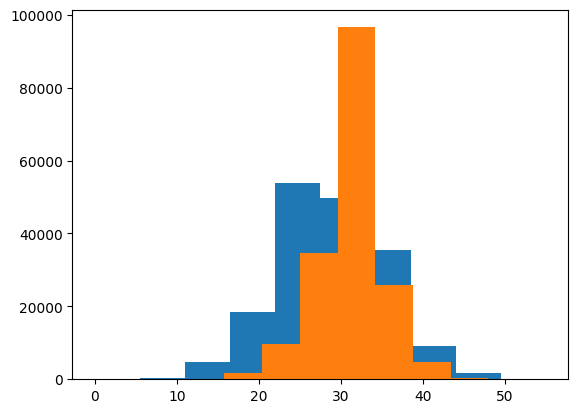

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(a_comparisons)
plt.hist(p_comparisons)

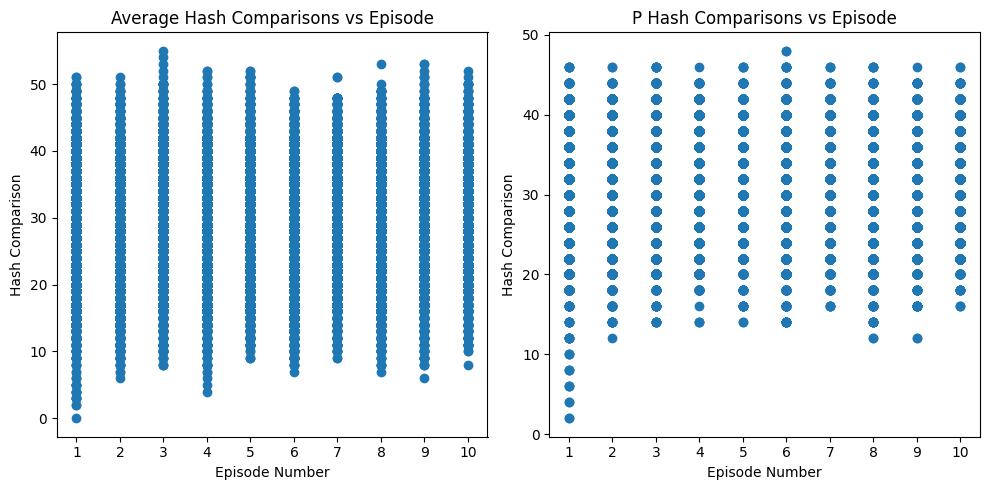

In [36]:
import matplotlib.pyplot as plt

# compare the hashes of the current episode with the hashes of the existing episodes
a_comparisons = []
p_comparisons = []
a_episode_numbers = []
p_episode_numbers = []

for a_hash, phash in zip(average_hashes.values(), p_hashes.values()):
    for episode_number, episode_hashes in existing__average_hashes.items():
        for i, hash_val in enumerate(episode_hashes):
            a_comparisons.append(abs(a_hash - hash_val))
            a_episode_numbers.append(episode_number)
    for episode_number, episode_hashes in existing_p_hashes.items():
        for i, hash_val in enumerate(episode_hashes):
            p_comparisons.append(abs(phash - hash_val))
            p_episode_numbers.append(episode_number)

# Plotting the hash comparisons vs episode
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(a_episode_numbers, a_comparisons, 'o')
plt.title('Average Hash Comparisons vs Episode')
plt.xlabel('Episode Number')
plt.ylabel('Hash Comparison')

plt.subplot(1, 2, 2)
plt.plot(p_episode_numbers, p_comparisons, 'o')
plt.title('P Hash Comparisons vs Episode')
plt.xlabel('Episode Number')
plt.ylabel('Hash Comparison')

plt.tight_layout()
plt.show()

In [6]:
# make these into a dataframe
import pandas as pd
df= pd.DataFrame({'episode_number': p_episode_numbers, 'hash_comparison': p_comparisons})
# p_comparisons,p_episode_numbers

NameError: name 'p_episode_numbers' is not defined

In [7]:
import seaborn as sns
sns.histplot(x='episode_number', y='hash_comparison', data=df)

NameError: name 'df' is not defined

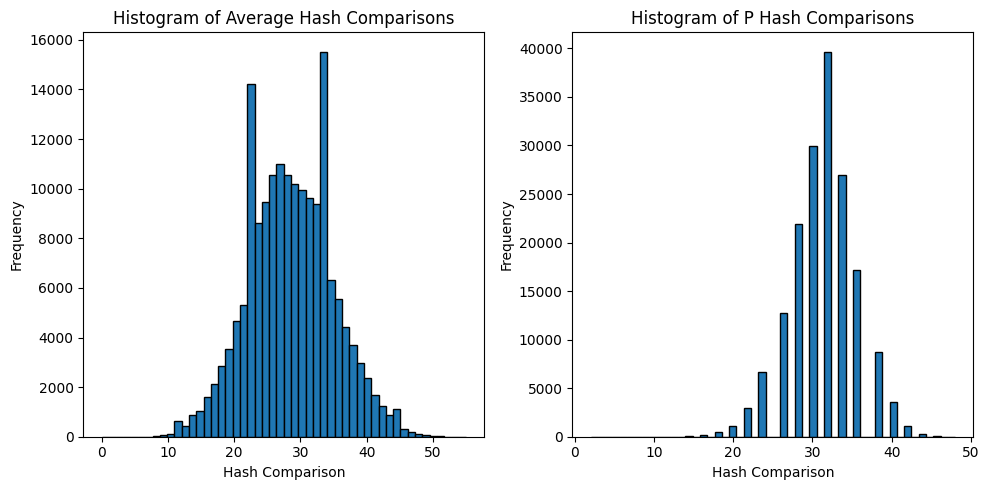

In [50]:
import matplotlib.pyplot as plt

# Assuming a_comparisons and p_comparisons are lists of hash comparisons

# Create a new figure
plt.figure(figsize=(10, 5))

# Create a histogram for average hash comparisons
plt.subplot(1, 2, 1)
plt.hist(a_comparisons, bins=50, edgecolor='black')
plt.title('Histogram of Average Hash Comparisons')
plt.xlabel('Hash Comparison')
plt.ylabel('Frequency')

# Create a histogram for p hash comparisons
plt.subplot(1, 2, 2)
plt.hist(p_comparisons, bins=50, edgecolor='black')
plt.title('Histogram of P Hash Comparisons')
plt.xlabel('Hash Comparison')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
from tqdm import tqdm
import numpy.random as npr
mkv_file = r'D:\Video\The Expanse\Season 1\The Expanse - S01E01.mkv'
metadata = iio.immeta(mkv_file)
total_frames = int(metadata['fps'] * metadata['duration'])
filename = os.path.basename(mkv_file)
# calculated average and phash hashes for each frame and store them in a dictionary

npr.seed(0)
# Create some random data
frames = np.random.randint(0,total_frames,100)
def calculate_hashes(frame_count):
    try:
        frame = iio.imread(mkv_file, index=frame_count, plugin="pyav")
        average_hash = calculate_image_hash(frame, False, 'average')
        p_hash = calculate_image_hash(frame, False, 'phash')
        return frame_count, average_hash, p_hash
    except Exception as e:
        print(f"Error in worker process: {e}")
        raise
processed_images= [calculate_hashes(image) for image in tqdm(frames)]

average_hashes = {i: avg for i, avg, _ in processed_images}
p_hashes = {i: p for i, _, p in processed_images}


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


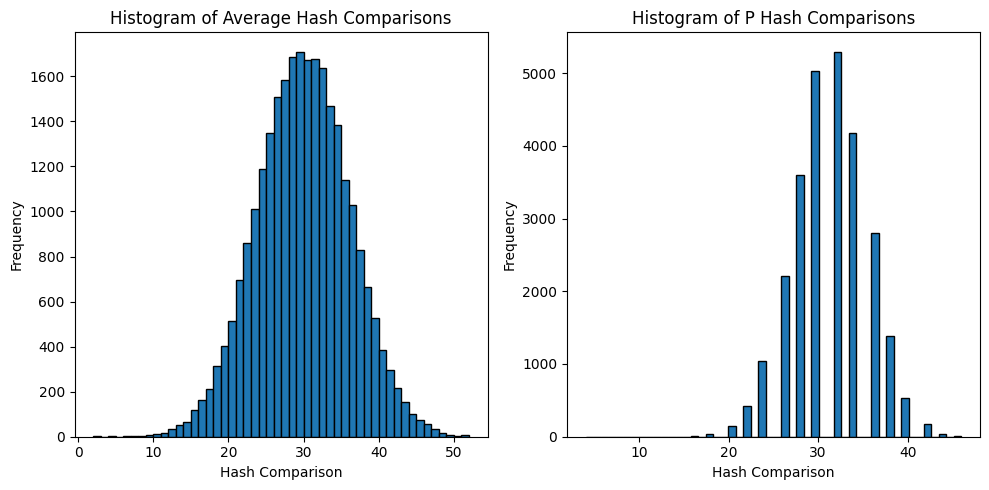

In [61]:
a_comparisons = []
p_comparisons = []
a_episode_numbers = []
p_episode_numbers = []

for a_hash, phash in zip(average_hashes.values(), p_hashes.values()):
    for episode_number, episode_hashes in existing__average_hashes.items():
        for i, hash_val in enumerate(episode_hashes):
            a_comparisons.append(abs(a_hash - hash_val))
            a_episode_numbers.append(episode_number)
    for episode_number, episode_hashes in existing_p_hashes.items():
        for i, hash_val in enumerate(episode_hashes):
            p_comparisons.append(abs(phash - hash_val))
            p_episode_numbers.append(episode_number)
# Assuming a_comparisons and p_comparisons are lists of hash comparisons

# Create a new figure
plt.figure(figsize=(10, 5))

# Create a histogram for average hash comparisons
plt.subplot(1, 2, 1)
plt.hist(a_comparisons, bins=50, edgecolor='black')
plt.title('Histogram of Average Hash Comparisons')
plt.xlabel('Hash Comparison')
plt.ylabel('Frequency')

# Create a histogram for p hash comparisons
plt.subplot(1, 2, 2)
plt.hist(p_comparisons, bins=50, edgecolor='black')
plt.title('Histogram of P Hash Comparisons')
plt.xlabel('Hash Comparison')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: xlabel='episode_number', ylabel='hash_comparison'>

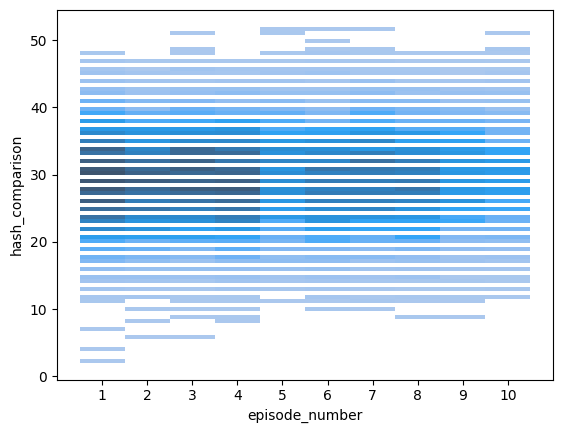

In [63]:
df= pd.DataFrame({'episode_number': a_episode_numbers, 'hash_comparison': a_comparisons})
import seaborn as sns
sns.histplot(x='episode_number', y='hash_comparison', data=df)

In [8]:
# get the 95% confidence interval of the hash comparisons
from scipy import stats
confidence = 0.95
import numpy as np, scipy.stats as st



import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

df.groupby('episode_number')['hash_comparison'].apply(mean_confidence_interval)

NameError: name 'df' is not defined

In [72]:
df.groupby('episode_number').min(3)

,hash_comparison
episode_number,
1,2
10,12
2,6
3,6
4,8
5,11
6,10
7,10
8,9


In [73]:
# calculate the mean of the lowest 5 hash comparisons for each episode
df.groupby('episode_number')['hash_comparison'].apply(lambda x: np.mean(sorted(x)[:5]))

episode_number
1      7.0
10    12.6
2      9.2
3      9.2
4      9.2
5     12.6
6     10.2
7     10.8
8     10.0
9     11.2
Name: hash_comparison, dtype: float64

In [13]:
# for each file in this folder that ends with .mkv : D:\Video\The Expanse\Season 1, calculate the average hash for 100 random frames and compare them to the existing hashes for the show. Then calculate the mean of the lowest 5 hash comparisons for each episode and store them in a dictionary with the episode number as the key.
import pandas as pd
import numpy.random as npr
season_path = r'D:\Video\The Expanse\Season 2'
mkv_files = [os.path.join(season_path, f) for f in os.listdir(season_path) if f.endswith(".mkv")]
def calculate_hashes(frame_count):
    try:
        frame = iio.imread(mkv_file, index=frame_count, plugin="pyav")
        average_hash = calculate_image_hash(frame, False, 'average')
        p_hash = calculate_image_hash(frame, False, 'phash')
        return frame_count, average_hash, p_hash
    except Exception as e:
        print(f"Error in worker process: {e}")
        raise
#calculate the average hash for 100 random frames and compare them to the existing hashes for the show.
def process_file(mkv_file):
    metadata = iio.immeta(mkv_file)
    total_frames = int(metadata['fps'] * metadata['duration'])
    filename = os.path.basename(mkv_file)
    npr.seed(0)
    # Create some random data
    frames = np.random.randint(0, total_frames, 500)
    processed_images = [calculate_hashes(image) for image in tqdm(frames)]
    average_hashes = {i: avg for i, avg, _ in processed_images}
    a_comparisons = []

    a_episode_numbers = []

    for a_hash in average_hashes.values():
        for episode_number, episode_hashes in existing__average_hashes.items():
            for i, hash_val in enumerate(episode_hashes):
                a_comparisons.append(abs(a_hash - hash_val))
                a_episode_numbers.append(episode_number)
    df = pd.DataFrame({'episode_number': a_episode_numbers, 'hash_comparison': a_comparisons})
    
    a_mean_lowest_5 = df.groupby('episode_number')['hash_comparison'].apply(lambda x: np.mean(sorted(x)[:5]))
    return a_mean_lowest_5

results = {}
for mkv_file in mkv_files:
    a_mean_lowest_5= process_file(mkv_file)
    results[mkv_file] = {'average': a_mean_lowest_5}
    

  0%|          | 0/500 [00:00<?, ?it/s]Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
  0%|          | 1/500 [00:00<04:43,  1.76it/s]Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
  0%|          | 2/500 [00:00<02:39,  3.12it/s]Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
  1%|          | 3/500 [00:00<02:09,  3.84it/s]Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
  1%|          | 4/500 [00:01<01:51,

Error in worker process: 


StopIteration: 

In [ ]:
results

{'D:\\Video\\The Expanse\\Season 1\\The Expanse - S01E01.mkv': {'average': episode_number
  1      0.6
  10    10.2
  2      6.6
  3      6.6
  4      8.4
  5      9.8
  6      6.4
  7      9.8
  8      8.4
  9     10.4
  Name: hash_comparison, dtype: float64},
 'D:\\Video\\The Expanse\\Season 1\\The Expanse - S01E01_2.mkv': {'average': episode_number
  1      7.2
  10     7.0
  2      7.2
  3      9.8
  4      8.0
  5      8.8
  6      7.2
  7      8.4
  8     10.0
  9      4.8
  Name: hash_comparison, dtype: float64},
 'D:\\Video\\The Expanse\\Season 1\\The Expanse - S01E02.mkv': {'average': episode_number
  1      8.6
  10     9.2
  2      8.2
  3     10.2
  4      9.2
  5      8.4
  6      1.6
  7      9.6
  8     10.0
  9      8.6
  Name: hash_comparison, dtype: float64},
 'D:\\Video\\The Expanse\\Season 1\\The Expanse - S01E03.mkv': {'average': episode_number
  1     8.0
  10    8.4
  2     7.2
  3     0.6
  4     8.0
  5     9.8
  6     8.2
  7     9.4
  8     9.4
  9     9.2
  

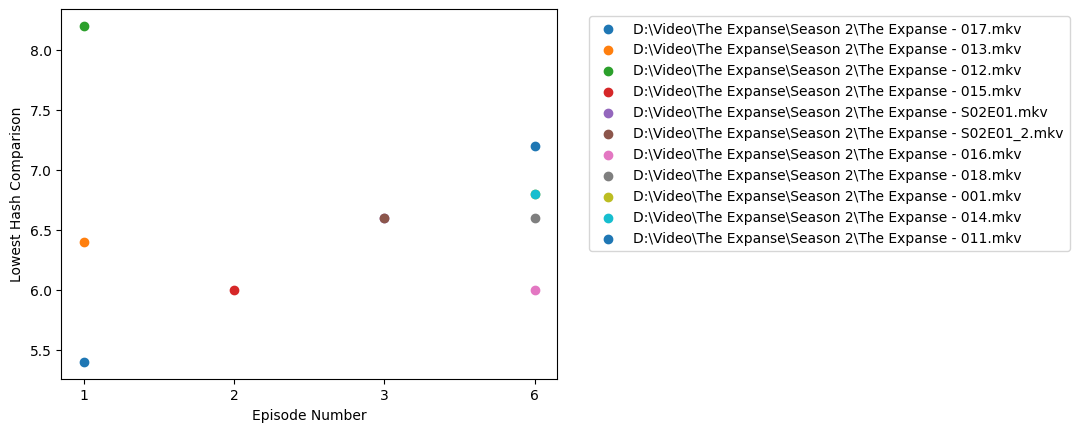

In [14]:
# make a scatter plot of the lowest hash comparisons for each episode for each file
import matplotlib.pyplot as plt

# Initialize lists to hold x values, y values, and labels
x_values = []
y_values = []
labels = []

for mkv_file, data in results.items():
    y= data['average'].min()
    x= data['average'].index[data['average'].argmin()]
    # Append the values to the respective lists
    x_values.append(x)
    y_values.append(y)
    labels.append(mkv_file)

# Combine x_values, y_values, and labels into a single list of tuples
data = list(zip(x_values, y_values, labels))

# Sort the data by the x_values (the first element of each tuple)
data.sort()

# Unzip the sorted data back into x_values, y_values, and labels
x_values, y_values, labels = zip(*data)

# Now plot the values
for i in range(len(x_values)):
    plt.scatter(x_values[i], y_values[i], label=labels[i])

plt.xlabel('Episode Number')
plt.ylabel('Lowest Hash Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [1]:
import os
import imageio.v3 as iio
import pandas as pd
import numpy as np
import numpy.random as npr
from concurrent.futures import ThreadPoolExecutor
import imagehash
import json
from PIL import Image
import traceback
from loguru import logger
logger.add("hashing.log", rotation="10 MB")


def calculate_image_hash(data_or_path: bytes | str, is_path: bool = True,hash_type='average') -> imagehash.ImageHash:
    """
    Calculate perceptual hash for given image data or file path.

    Args:
        data_or_path (bytes | str): If is_path is True, it's treated as a file path to an image;
            otherwise, it's binary data of an image.
        is_path (bool, optional): Flag indicating whether data_or_path is a file path (True) or binary data (False).
            Defaults to True.

    Returns:
        imagehash.ImageHash: The perceptual hash of the image.
    """
    if is_path:
        image = Image.open(data_or_path)
    else:
        # image = Image.open(BytesIO(data_or_path))
        image = Image.fromarray(data_or_path)
    if hash_type == 'average':
        hash = imagehash.average_hash(image)
    elif hash_type == 'phash':
        hash = imagehash.phash(image)
    return hash

def load_show_hashes(show_name, hash_type):
    """
    Load the hashes for a given show from a JSON file.

    Args:
        show_name (str): The name of the show.
        hash_type (str): The type of hash to load.

    Returns:
        dict: A dictionary containing the loaded hashes, or an empty dictionary if the JSON file doesn't exist.
    """
    json_file_path = os.path.join(CACHE_DIR, f"{show_name}_hashes_{hash_type}.json")
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            return json.load(json_file)
    else:
        return {}

def store_show_hashes(show_name, show_hashes,hash_type):
    """
    Stores the hashes of a show in a JSON file.

    Args:
        show_name (str): The name of the show.
        show_hashes (dict): A dictionary containing the hashes of the show.

    Returns:
        None
    """
    json_file_path = os.path.join(CACHE_DIR, f"{show_name}_hashes_{hash_type}.json")
    with open(json_file_path, 'w') as json_file:
        json.dump(show_hashes, json_file, default=lambda x: x.result() if isinstance(x, ThreadPoolExecutor) else x)
    logger.info(f"Show hashes saved to {json_file_path}")
def preprocess_hashes(show_name, show_id, seasons_to_process, hash_type):
    """
    Preprocess hashes by loading them from the file or fetching and hashing them if necessary.

    Args:
        show_name (str): The name of the show.
        show_id (str): The TMDb ID of the show.
        seasons_to_process (list): A list of season numbers to process.
        hash_type (str): The type of hash to use for comparison.

    Returns:
        dict: A dictionary containing the hashes for each season.
    """
    for season_number in seasons_to_process:
        existing_hashes = load_show_hashes(show_name, hash_type)

    # Convert hash values from strings back to appropriate type (e.g., integers)
    for season, episodes in existing_hashes.items():
        for episode_number, episode_hashes in episodes.items():
            existing_hashes[season][episode_number] = [imagehash.hex_to_hash(hash_str) for hash_str in episode_hashes]
    return existing_hashes
def get_list_of_frames(mkv_file):
    """
    Get a list of all frames in an MKV file.

    Parameters:
    mkv_file (str): The path to the MKV file.

    Returns:
    list: A list of all frames in the MKV file.
    """
    metadata = iio.immeta(mkv_file)
    total_frames = int(metadata['fps'] * metadata['duration'])
    # Create a list of all frames
    all_frames = list(range(total_frames-1))
    return all_frames
def calculate_hashes(mkv_file, frame_count):
    """
    Calculate the image hash for a given frame in an MKV file.

    Args:
        mkv_file (str): The path to the MKV file.
        frame_count (int): The index of the frame to calculate the hash for.

    Returns:
        tuple: A tuple containing the frame count and the calculated image hash.

    Raises:
        Exception: If an error occurs during the calculation.

    """
    try:
        frame = iio.imread(mkv_file, index=frame_count, plugin="pyav")
        average_hash = calculate_image_hash(frame, False, 'average')
        return frame_count, average_hash
    except Exception as e:
        logger.info(f"Error in worker process: {e}")
        traceback.print_exc()  # Print the traceback
        raise
# def process_file(mkv_file, frames, existing_average_hashes):
#     processed_images = [calculate_hashes(mkv_file, image) for image in frames]
#     average_hashes = {i: avg for i, avg in processed_images}
#     a_comparisons = []
#     a_episode_numbers = []

#     for a_hash in average_hashes.values():
#         for episode_number, episode_hashes in existing_average_hashes.items():
#             for hash_val in episode_hashes:
#                 a_comparisons.append(abs(a_hash - hash_val))
#                 a_episode_numbers.append(episode_number)
#     df = pd.DataFrame({'episode_number': a_episode_numbers, 'hash_comparison': a_comparisons})
#     a_mean_lowest_5 = df.groupby('episode_number')['hash_comparison'].apply(lambda x: np.mean(sorted(x)[:5]))
#     return a_mean_lowest_5
# def process_files(args):
#     i, frames, mkv_file, existing_average_hashes = args
#     print(f"Processing file {i+1}: {mkv_file}")
#     a_mean_lowest_5 = process_file(mkv_file, frames, existing_average_hashes)
#     return mkv_file, {'average': a_mean_lowest_5}
# Initialize an empty dictionary
hash_data = {}

def process_file(mkv_file, frames, existing_average_hashes):
    processed_images = [calculate_hashes(mkv_file, image) for image in frames]
    average_hashes = {i: avg for i, avg in processed_images}
    a_comparisons = []
    a_episode_numbers = []

    for a_hash in average_hashes.values():
        for episode_number, episode_hashes in existing_average_hashes.items():
            for hash_val in episode_hashes:
                a_comparisons.append(abs(a_hash - hash_val))
                a_episode_numbers.append(episode_number)
    # Return the comparisons and episodes along with the filename
    return mkv_file, a_comparisons, a_episode_numbers

def process_files(args):
    i, frames, mkv_file, existing_average_hashes = args
    logger.info(f"Processing file {i+1}: {mkv_file}")
    mkv_file, a_comparisons, a_episode_numbers = process_file(mkv_file, frames, existing_average_hashes)
    # Check if the filename key exists in hash_data
    if mkv_file not in hash_data:
        # If not, create a new dictionary for that filename
        hash_data[mkv_file] = {
            'hash_comparisons': [],
            'episode_numbers': [],
            'frames_processed': []
        }
    
    # Extend the lists for hash_comparisons, episode_numbers, and frames_processed
    hash_data[mkv_file]['hash_comparisons'].extend(a_comparisons)
    hash_data[mkv_file]['episode_numbers'].extend(a_episode_numbers)
    hash_data[mkv_file]['frames_processed'].append(frames)
    # Calculate a_mean_lowest_5 using all the comparisons for that file
    df = pd.DataFrame({'episode_number': hash_data[mkv_file]['episode_numbers'], 'hash_comparison': hash_data[mkv_file]['hash_comparisons']})
    a_mean_lowest = df.groupby('episode_number')['hash_comparison'].apply(lambda x: np.mean(sorted(x)[:3]))
    return mkv_file, {'average': a_mean_lowest}
CACHE_DIR = r'C:\Users\Jonathan\.mkv-episode-matcher\cache'
season_path = r'E:\The Expanse\Season 3'
existing_average_hashes = preprocess_hashes('The Expanse', 1234, [3],'average')
existing_average_hashes = existing_average_hashes['3']
mkv_files = [os.path.join(season_path, f) for f in os.listdir(season_path) if f.endswith(".mkv")]
# frames_list = [get_list_of_frames(mkv_file) for mkv_file in mkv_files]
frames_dict = {mkv_file: get_list_of_frames(mkv_file) for mkv_file in mkv_files}
df = pd.DataFrame()
# Initialize the dictionaries

# Add existing_average_hashes data structure here
for i in range(30):
    logger.info(f"Processing iteration {i+1}")
    frames_to_process = {mkv_file: npr.choice(frames_dict[mkv_file], 100, replace=False) for mkv_file in mkv_files}

    with ThreadPoolExecutor() as executor:
        if frames_to_process:
            try:
                results = dict(executor.map(process_files, [(j, frames, mkv_file, existing_average_hashes) for j, (mkv_file, frames) in enumerate(frames_to_process.items())]))
            except RuntimeError:
                print("An error occurred while processing the video frames.")
        else:
            print("No more frames to process.")

    for mkv_file, frames in frames_to_process.items():
        for frame in frames:
            if frame in frames_dict[mkv_file]:
                frames_dict[mkv_file].remove(frame)
    x_values = []
    y_values = []
    labels = []
    for mkv_file, data in results.items():
        y = data['average'].min()
        x = data['average'].idxmin()
        x_values.append(x)
        y_values.append(y)
        labels.append(mkv_file)
    if df.empty:
        data = list(zip(x_values, y_values, labels))
        x_values, y_values, labels = zip(*data)
        df = pd.DataFrame([x_values, y_values, labels]).T
        df.columns =    ['episode_number', 'lowest_hash_comparison', 'filename']
        # convert the episode number to an integer
        df['episode_number'] = df['episode_number'].astype(int)
        # Sort the DataFrame by episode number

    else:
        for x, y, label in zip(x_values, y_values, labels):
            if label in df['filename'].values:
                df.loc[df['filename'] == label, 'lowest_hash_comparison'] = y
                df.loc[df['filename'] == label, 'episode_number'] = int(x)
            else:
                new_row = {'episode_number': x, 'lowest_hash_comparison': y, 'filename': label}
                df = df.append(new_row, ignore_index=True)

    # make he episode number column numeric
    # df['episode_number'] = pd.to_numeric(df['episode_number'], errors='coerce') 
    df = df.sort_values(by='episode_number', ascending=True)
    logger.info(df)
    mkv_files = df.loc[df.episode_number.duplicated(keep=False),'filename'].to_list()
    # matching_duplicates = len(x_values) - len(set(x_values)) 
    logger.info(f"Matching duplicates: {len(mkv_files)}")
    if len(mkv_files) == 0:
        break



2024-03-30 14:10:30.541 | INFO     | __main__:<module>:200 - Processing iteration 1
2024-03-30 14:10:30.613 | INFO     | __main__:process_files:169 - Processing file 1: E:\The Expanse\Season 3\The Expanse - 000.mkv
2024-03-30 14:10:30.615 | INFO     | __main__:process_files:169 - Processing file 2: E:\The Expanse\Season 3\The Expanse - 001.mkv
2024-03-30 14:10:30.615 | INFO     | __main__:process_files:169 - Processing file 3: E:\The Expanse\Season 3\The Expanse - 002.mkv
2024-03-30 14:10:30.616 | INFO     | __main__:process_files:169 - Processing file 4: E:\The Expanse\Season 3\The Expanse - 003.mkv
2024-03-30 14:10:30.618 | INFO     | __main__:process_files:169 - Processing file 5: E:\The Expanse\Season 3\The Expanse - 004.mkv
2024-03-30 14:10:30.619 | INFO     | __main__:process_files:169 - Processing file 6: E:\The Expanse\Season 3\The Expanse - 005.mkv
2024-03-30 14:10:30.619 | INFO     | __main__:process_files:169 - Processing file 7: E:\The Expanse\Season 3\The Expanse - 006.mkv

An error occurred while processing the video frames.


2024-03-30 14:17:04.311 | INFO     | __main__:<module>:246 -     episode_number lowest_hash_comparison  \
3                1               1.333333   
12               1                    5.0   
0                1               5.666667   
2                2               4.666667   
4                3               3.333333   
5                4               9.333333   
7                5               3.333333   
8                6               6.333333   
6                7               2.333333   
9                8               8.333333   
10               9               3.666667   
11              10                    7.0   
1               11                    7.0   
13              13                    6.0   

                                         filename  
3   E:\The Expanse\Season 3\The Expanse - 003.mkv  
12  E:\The Expanse\Season 3\The Expanse - 012.mkv  
0   E:\The Expanse\Season 3\The Expanse - 000.mkv  
2   E:\The Expanse\Season 3\The Expanse - 002.mkv  
4  

In [7]:
results

{'E:\\The Expanse\\Season 3\\The Expanse - 000.mkv': {'average': episode_number
  1      8.333333
  10    10.333333
  11    10.333333
  12    12.666667
  13    12.666667
  2     14.333333
  3     13.666667
  4     10.333333
  5     14.333333
  6      9.666667
  7     10.333333
  8     12.000000
  9     10.000000
  Name: hash_comparison, dtype: float64},
 'E:\\The Expanse\\Season 3\\The Expanse - 001.mkv': {'average': episode_number
  1      8.666667
  10    11.333333
  11    10.333333
  12    14.000000
  13    13.666667
  2     13.666667
  3     13.666667
  4     10.333333
  5     13.333333
  6     11.666667
  7      9.666667
  8     12.333333
  9     12.666667
  Name: hash_comparison, dtype: float64},
 'E:\\The Expanse\\Season 3\\The Expanse - 002.mkv': {'average': episode_number
  1      9.333333
  10    10.666667
  11    11.000000
  12    14.000000
  13    13.666667
  2      4.000000
  3     13.666667
  4     10.666667
  5     12.666667
  6     10.666667
  7     11.000000
  8     10

In [12]:
# sort by episode number then lowest hash comparison
df = df.sort_values(by=['episode_number', 'lowest_hash_comparison'], ascending=[True, True])
df

,episode_number,lowest_hash_comparison,filename
3,1,1.0,E:\The Expanse\Season 3\The Expanse - 003.mkv
0,1,4.333333,E:\The Expanse\Season 3\The Expanse - 000.mkv
2,2,4.666667,E:\The Expanse\Season 3\The Expanse - 002.mkv
4,3,3.333333,E:\The Expanse\Season 3\The Expanse - 004.mkv
5,4,9.333333,E:\The Expanse\Season 3\The Expanse - 005.mkv
7,5,3.333333,E:\The Expanse\Season 3\The Expanse - 007.mkv
8,6,6.333333,E:\The Expanse\Season 3\The Expanse - 008.mkv
6,7,2.333333,E:\The Expanse\Season 3\The Expanse - 006.mkv
9,8,8.333333,E:\The Expanse\Season 3\The Expanse - 009.mkv
10,9,3.666667,E:\The Expanse\Season 3\The Expanse - 010.mkv


In [10]:
# iterate over the filenames and print the episodes
for mkv_file in df.filename.unique():
    print(mkv_file)
    print(df.loc[df['filename'] == mkv_file, 'episode_number'].values[0])

E:\The Expanse\Season 3\The Expanse - 003.mkv
1
E:\The Expanse\Season 3\The Expanse - 000.mkv
1
E:\The Expanse\Season 3\The Expanse - 002.mkv
2
E:\The Expanse\Season 3\The Expanse - 004.mkv
3
E:\The Expanse\Season 3\The Expanse - 005.mkv
4
E:\The Expanse\Season 3\The Expanse - 007.mkv
5
E:\The Expanse\Season 3\The Expanse - 008.mkv
6
E:\The Expanse\Season 3\The Expanse - 006.mkv
7
E:\The Expanse\Season 3\The Expanse - 009.mkv
8
E:\The Expanse\Season 3\The Expanse - 010.mkv
9
E:\The Expanse\Season 3\The Expanse - 011.mkv
10
E:\The Expanse\Season 3\The Expanse - 001.mkv
11
E:\The Expanse\Season 3\The Expanse - 012.mkv
12
E:\The Expanse\Season 3\The Expanse - 013.mkv
13


In [18]:
# make he episode number column numeric
df['episode_number'] = pd.to_numeric(df['episode_number'], errors='coerce') 

In [17]:
df.loc[df['filename'] == labels[0], 'lowest_hash_comparison'] = 5

In [23]:
df.loc[df.episode_number.duplicated(),'filename'].to_list()

['E:\\The Expanse\\Season 3\\The Expanse - 000.mkv',
 'E:\\The Expanse\\Season 3\\The Expanse - 004.mkv',
 'E:\\The Expanse\\Season 3\\The Expanse - 012.mkv',
 'E:\\The Expanse\\Season 3\\The Expanse - 007.mkv',
 'E:\\The Expanse\\Season 3\\The Expanse - 009.mkv']

In [36]:
# Create a dictionary to store the episode matches for each file
episode_matches = {}

# Initial processing
for i in range(30):
    print(f"Processing iteration {i+1}")
    frames_to_process = [npr.choice(frames, 20, replace=False) for frames in frames_list]
    # print(f"Frames to process: {frames_to_process}")
    # print(f'Frames remaining: {frames_list}')
    with ThreadPoolExecutor() as executor:
        try:
            results = dict(executor.map(process_files, [(j, frames, mkv_file, existing_average_hashes) for j, frames, mkv_file in zip(range(len(frames_to_process)), frames_to_process, mkv_files)]))
        except StopIteration:
            print("No more frames to process.")
    
    # Update episode_matches with the episode matches for each file
    for mkv_file, data in results.items():
        episode_number = data['average'].idxmin()
        if mkv_file in episode_matches:
            episode_matches[mkv_file].append(episode_number)
        else:
            episode_matches[mkv_file] = [episode_number]
    print(episode_matches)
    # Check for conflicts
    conflicts = [file for file, episodes in episode_matches.items() if len(set(episodes)) > 1]
    print(f"Conflicts: {conflicts}")
    # If there are no conflicts, break the loop
    if not conflicts:
        break

    # In the next iteration, only process the files that have conflicts
    mkv_files = conflicts

Processing iteration 1
Processing file 1: E:\The Expanse\Season 3\The Expanse - 000.mkv
Processing file 2: E:\The Expanse\Season 3\The Expanse - 001.mkv
Processing file 3: E:\The Expanse\Season 3\The Expanse - 002.mkv
Processing file 4: E:\The Expanse\Season 3\The Expanse - 003.mkv
Processing file 5: E:\The Expanse\Season 3\The Expanse - 004.mkv
Processing file 6: E:\The Expanse\Season 3\The Expanse - 005.mkv
Processing file 7: E:\The Expanse\Season 3\The Expanse - 006.mkv
Processing file 8: E:\The Expanse\Season 3\The Expanse - 007.mkv
Processing file 9: E:\The Expanse\Season 3\The Expanse - 008.mkv
Processing file 10: E:\The Expanse\Season 3\The Expanse - 009.mkv


Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options


Processing file 11: E:\The Expanse\Season 3\The Expanse - 010.mkvProcessing file 12: E:\The Expanse\Season 3\The Expanse - 011.mkv

Processing file 13: E:\The Expanse\Season 3\The Expanse - 012.mkv
Processing file 14: E:\The Expanse\Season 3\The Expanse - 013.mkv


Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
Could not find codec parameters for stream 3 (Subtitle: hdmv_pgs_subtitle (pgssub)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
Could not find codec

{'E:\\The Expanse\\Season 3\\The Expanse - 000.mkv': ['1'], 'E:\\The Expanse\\Season 3\\The Expanse - 001.mkv': ['11'], 'E:\\The Expanse\\Season 3\\The Expanse - 002.mkv': ['2'], 'E:\\The Expanse\\Season 3\\The Expanse - 003.mkv': ['1'], 'E:\\The Expanse\\Season 3\\The Expanse - 004.mkv': ['3'], 'E:\\The Expanse\\Season 3\\The Expanse - 005.mkv': ['4'], 'E:\\The Expanse\\Season 3\\The Expanse - 006.mkv': ['7'], 'E:\\The Expanse\\Season 3\\The Expanse - 007.mkv': ['5'], 'E:\\The Expanse\\Season 3\\The Expanse - 008.mkv': ['6'], 'E:\\The Expanse\\Season 3\\The Expanse - 009.mkv': ['8'], 'E:\\The Expanse\\Season 3\\The Expanse - 010.mkv': ['9'], 'E:\\The Expanse\\Season 3\\The Expanse - 011.mkv': ['10'], 'E:\\The Expanse\\Season 3\\The Expanse - 012.mkv': ['7'], 'E:\\The Expanse\\Season 3\\The Expanse - 013.mkv': ['13']}
Conflicts: []


In [37]:
x_values = []
y_values = []
labels = []

for mkv_file, data in results.items():
    y = data['average'].min()
    x = data['average'].idxmin()
    x_values.append(x)
    y_values.append(y)
    labels.append(mkv_file)

data = list(zip(x_values, y_values, labels))
data.sort()
x_values, y_values, labels = zip(*data)
df = pd.DataFrame([x_values, y_values, labels]).T
df.columns =    ['episode_number', 'lowest_hash_comparison', 'filename']
# convert the episode number to an integer
df['episode_number'] = df['episode_number'].astype(int)
# Sort the DataFrame by episode number
df = df.sort_values(by='episode_number', ascending=True)
print(df)
matching_duplicates = len(x_values) - len(set(x_values)) 


    episode_number lowest_hash_comparison  \
0                1                    1.0   
1                1               7.333333   
5                2               2.666667   
6                3               3.333333   
7                4               2.666667   
8                5                    2.0   
9                6               1.333333   
10               7               3.333333   
11               7                    5.0   
12               8               3.666667   
13               9               2.666667   
2               10               4.333333   
3               11               6.333333   
4               13                    3.0   

                                         filename  
0   E:\The Expanse\Season 3\The Expanse - 003.mkv  
1   E:\The Expanse\Season 3\The Expanse - 000.mkv  
5   E:\The Expanse\Season 3\The Expanse - 002.mkv  
6   E:\The Expanse\Season 3\The Expanse - 004.mkv  
7   E:\The Expanse\Season 3\The Expanse - 005.mkv  
8   E:\The E

In [41]:
results

{'E:\\The Expanse\\Season 3\\The Expanse - 000.mkv': {'average': episode_number
  1      7.333333
  10     9.000000
  11     8.333333
  12     9.000000
  13    12.000000
  2     12.000000
  3     13.333333
  4      7.666667
  5     13.000000
  6      9.666667
  7      8.000000
  8      8.333333
  9     10.666667
  Name: hash_comparison, dtype: float64},
 'E:\\The Expanse\\Season 3\\The Expanse - 001.mkv': {'average': episode_number
  1      7.333333
  10    10.666667
  11     6.333333
  12    11.000000
  13    10.666667
  2     13.000000
  3     12.000000
  4      9.333333
  5     10.333333
  6      9.666667
  7      9.333333
  8     10.333333
  9      9.666667
  Name: hash_comparison, dtype: float64},
 'E:\\The Expanse\\Season 3\\The Expanse - 002.mkv': {'average': episode_number
  1      6.666667
  10     7.000000
  11     9.333333
  12    12.000000
  13    10.000000
  2      2.666667
  3     12.000000
  4      7.666667
  5     12.000000
  6      8.666667
  7      8.333333
  8     11

In [33]:
df = pd.DataFrame([x_values, y_values, labels]).T
df.columns =    ['episode_number', 'lowest_hash_comparison', 'filename']
# convert the episode number to an integer
df['episode_number'] = df['episode_number'].astype(int)
# Sort the DataFrame by episode number
df = df.sort_values(by='episode_number', ascending=True)
df

,episode_number,lowest_hash_comparison,filename
0,1,1.0,E:\The Expanse\Season 3\The Expanse - 003.mkv
1,1,7.333333,E:\The Expanse\Season 3\The Expanse - 000.mkv
6,2,3.666667,E:\The Expanse\Season 3\The Expanse - 002.mkv
7,3,3.333333,E:\The Expanse\Season 3\The Expanse - 004.mkv
8,4,2.666667,E:\The Expanse\Season 3\The Expanse - 005.mkv
9,5,2.0,E:\The Expanse\Season 3\The Expanse - 007.mkv
10,6,1.333333,E:\The Expanse\Season 3\The Expanse - 008.mkv
11,7,3.333333,E:\The Expanse\Season 3\The Expanse - 006.mkv
12,8,4.0,E:\The Expanse\Season 3\The Expanse - 009.mkv
13,9,2.666667,E:\The Expanse\Season 3\The Expanse - 010.mkv


In [31]:
len(set(x_values)) - len(x_values)

-1

In [3]:
hash_data['E:\\The Expanse\\Season 3\\The Expanse - 000.mkv']['hash_comparisons']

[26,
 27,
 35,
 27,
 28,
 30,
 41,
 26,
 23,
 29,
 31,
 24,
 34,
 32,
 24,
 34,
 34,
 31,
 32,
 27,
 32,
 30,
 29,
 18,
 36,
 30,
 20,
 37,
 31,
 31,
 44,
 29,
 20,
 43,
 31,
 22,
 24,
 24,
 30,
 35,
 26,
 35,
 42,
 40,
 39,
 33,
 38,
 25,
 23,
 25,
 43,
 33,
 34,
 34,
 35,
 23,
 29,
 26,
 36,
 26,
 32,
 34,
 27,
 36,
 34,
 34,
 26,
 28,
 33,
 21,
 25,
 29,
 34,
 28,
 28,
 24,
 29,
 33,
 24,
 17,
 30,
 33,
 30,
 28,
 31,
 40,
 28,
 34,
 38,
 29,
 30,
 22,
 24,
 34,
 35,
 30,
 34,
 28,
 22,
 27,
 28,
 32,
 26,
 26,
 29,
 27,
 34,
 27,
 29,
 24,
 26,
 26,
 24,
 15,
 33,
 24,
 26,
 32,
 33,
 29,
 31,
 25,
 23,
 36,
 22,
 26,
 15,
 36,
 31,
 31,
 27,
 24,
 32,
 27,
 32,
 28,
 23,
 21,
 33,
 29,
 39,
 33,
 30,
 20,
 29,
 28,
 29,
 28,
 31,
 26,
 27,
 19,
 35,
 23,
 26,
 17,
 30,
 24,
 28,
 29,
 25,
 38,
 28,
 31,
 30,
 33,
 25,
 33,
 25,
 17,
 37,
 22,
 31,
 33,
 22,
 27,
 37,
 29,
 20,
 42,
 29,
 22,
 30,
 29,
 31,
 25,
 25,
 28,
 39,
 33,
 23,
 31,
 24,
 32,
 18,
 19,
 30,
 25,
 26,
 36,


In [10]:
df = pd.DataFrame({'episode_number': hash_data['E:\\The Expanse\\Season 3\\The Expanse - 000.mkv']['episode_numbers'], 'hash_comparison': hash_data['E:\\The Expanse\\Season 3\\The Expanse - 000.mkv']['hash_comparisons']})
a_mean_lowest_5 = df.groupby('episode_number')['hash_comparison'].apply(lambda x: np.mean(sorted(x)[:5]))
a_mean_lowest_5

episode_number
1      7.0
10     7.2
11     9.6
12    10.2
13    11.6
2      9.2
3     13.0
4      8.4
5     11.0
6     10.0
7      8.2
8     10.4
9     10.6
Name: hash_comparison, dtype: float64

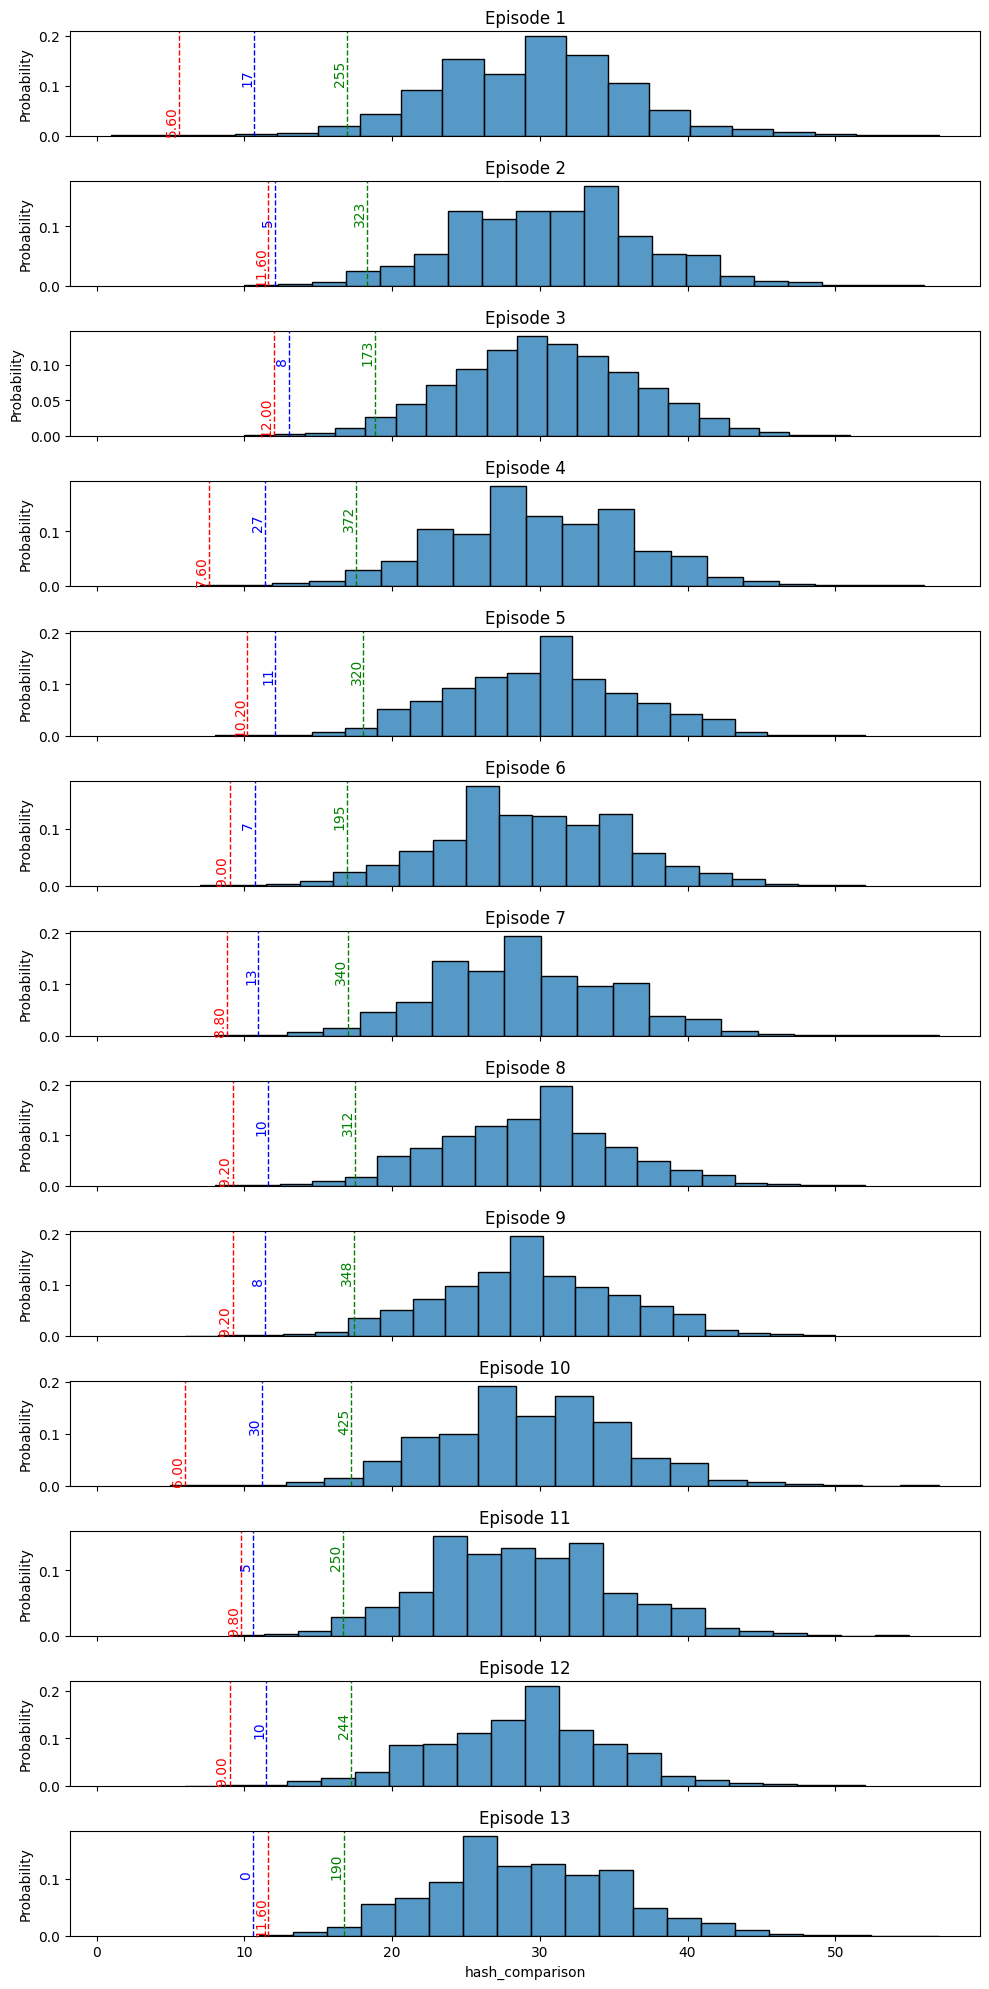

In [75]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy.stats

# def mean_confidence_interval(data, confidence=0.9999):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h
# f, axes = plt.subplots(len(df.episode_number.unique()), 1, figsize=(10, 20), sharex=True)
# for ax, episode_number in zip(axes, df.episode_number.unique()):
#     sns.histplot(x='hash_comparison', data=df.loc[df['episode_number'] == f'{episode_number}'],ax=ax,bins=20, stat='probability')
#     ax.set_title(f'Episode {episode_number}')
#     # add the mean of the lowest 5 hash comparisons
#     mean_lowest_5 = a_mean_lowest_5.loc[episode_number]
#     ax.axvline(mean_lowest_5, color='r', linestyle='dashed', linewidth=1)
#     ax.text(mean_lowest_5, 0, f'{mean_lowest_5:.2f}', rotation=90, va='bottom', ha='right', color='r')
#     # # add the mean of all hash comparisons
#     # mean_all = df.loc[df['episode_number'] == f'{episode_number}']['hash_comparison'].mean()
#     # ax.axvline(mean_all, color='g', linestyle='dashed', linewidth=1)
#     # ax.text(mean_all, 0, f'{mean_all:.2f}', rotation=90, va='bottom', ha='right', color='g')
#     # add a line for 2 and 3 standard deviations
#     mean = df.loc[df['episode_number'] == f'{episode_number}']['hash_comparison'].mean()
#     std = df.loc[df['episode_number'] == f'{episode_number}']['hash_comparison'].std()

#     # add lines for 2 and 3 standard deviations
#     ax.axvline(mean - 2 * std, color='g', linestyle='dashed', linewidth=1)
#     ax.axvline(mean - 3 * std, color='b', linestyle='dashed', linewidth=1)
#     # count the number of values outside of 2 and 3 standard deviations
#     count_2std = len(df.loc[(df['episode_number'] == f'{episode_number}') & (df['hash_comparison'] < mean - 2 * std)])
#     count_3std = len(df.loc[(df['episode_number'] == f'{episode_number}') & (df['hash_comparison'] < mean - 3 * std)])
#     ax.text(mean - 2 * std, 0.1, f'{count_2std}', rotation=90, va='bottom', ha='right', color='g')
#     ax.text(mean - 3 * std, 0.1, f'{count_3std}', rotation=90, va='bottom', ha='right', color='b')
# plt.tight_layout()

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

mean = df['hash_comparison'].mean()
std = df['hash_comparison'].std()
f, axes = plt.subplots(len(df.episode_number.unique()), 1, figsize=(10, 20), sharex=True)
for ax, episode_number in zip(axes, df.episode_number.unique()):
    sns.histplot(x='hash_comparison', data=df.loc[df['episode_number'] == f'{episode_number}'],ax=ax,bins=20, stat='probability')
    ax.set_title(f'Episode {episode_number}')

    # # add the mean of all hash comparisons
    # mean_all = df.loc[df['episode_number'] == f'{episode_number}']['hash_comparison'].mean()
    # ax.axvline(mean_all, color='g', linestyle='dashed', linewidth=1)
    # ax.text(mean_all, 0, f'{mean_all:.2f}', rotation=90, va='bottom', ha='right', color='g')
    # add a line for 2 and 3 standard deviations


    # add lines for 2 and 3 standard deviations
    ax.axvline(mean - 2 * std, color='g', linestyle='dashed', linewidth=1)
    ax.axvline(mean - 3 * std, color='b', linestyle='dashed', linewidth=1)
    # count the number of values outside of 2 and 3 standard deviations
    count_2std = len(df.loc[(df['episode_number'] == f'{episode_number}') & (df['hash_comparison'] < mean - 2 * std)])
    count_3std = len(df.loc[(df['episode_number'] == f'{episode_number}') & (df['hash_comparison'] < mean - 3 * std)])
    ax.text(mean - 2 * std, 0.1, f'{count_2std}', rotation=90, va='bottom', ha='right', color='g')
    ax.text(mean - 3 * std, 0.1, f'{count_3std}', rotation=90, va='bottom', ha='right', color='b')
    mean_lowest = df.loc[(df['episode_number'] == f'{episode_number}') & (df['hash_comparison'] < mean - 3 * std),'hash_comparison'].median()
    ax.axvline(mean_lowest, color='r', linestyle='dashed', linewidth=1)
    ax.text(mean_lowest, 0, f'{mean_lowest:.2f}', rotation=90, va='bottom', ha='right', color='r')
plt.tight_layout()

NameError: name 'df' is not defined

In [11]:
# get lowest 5 hash comparisons for each episode
df.groupby('episode_number')['hash_comparison'].apply(lambda x: sorted(x)[:5])
# df.loc[(df['episode_number'] == f'1') & (df['hash_comparison'] < mean - 3 * std),'hash_comparison'] 

episode_number
1         [1, 7, 8, 8, 11]
10         [6, 6, 8, 8, 8]
11      [8, 9, 10, 10, 11]
12     [8, 10, 11, 11, 11]
13    [11, 11, 12, 12, 12]
2       [7, 7, 10, 10, 12]
3     [13, 13, 13, 13, 13]
4          [7, 8, 9, 9, 9]
5     [10, 11, 11, 11, 12]
6      [9, 10, 10, 10, 11]
7          [8, 8, 8, 8, 9]
8      [9, 10, 11, 11, 11]
9     [10, 10, 11, 11, 11]
Name: hash_comparison, dtype: object

In [12]:
df

,episode_number,hash_comparison
0,1,26
1,1,27
2,1,35
3,1,27
4,1,28
...,...,...
106995,13,32
106996,13,29
106997,13,22
106998,13,21
